In [1]:
import ee
import folium 
import geehydro
import numpy as np
import pandas as pd
import proplot as plot 
import matplotlib.pyplot as plt 
from ipygee import*
from pandas.plotting import register_matplotlib_converters

In [2]:
# Google earth engine
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AX4XfWhoFh_6jrglKc5lWEc6hpAehNZnMlD35G1CdtEH6h0ir_-QVkwyTaE

Successfully saved authorization token.


# Section 1: Downloading Malawi Veg Indices and their Visualization
### To download and save indices of multiple countries scroll down to "Section 2"

In [6]:
# collection = ee.ImageCollection('MODIS/006/MOD13A1').select('NDVI')

# coordinates of country boundaries
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

# Select Malawi feature from countries.
mal = ee.Feature(countries.filter(ee.Filter.eq('country_na', 'Malawi')).first())
# print("Malawi: ",mal)

In [ ]:
# # Use a function to iterate through months and calculate average NDVI
# months = ee.List.sequence(1, 12)
# # print("months",months)
# years = ee.List.sequence(2010, 2020)
# # print("years",years)

In [5]:
# Only run this cell if need to visualise on map
# Need to enter coordinates near the country to visual the country on the map
# e.g Malawi= 13.2543° S, 34.3015° E
Map = folium.Map(location=[-13.25, 34.5], zoom_start=8)
# superimpose malawi onto map
Map.addLayer(mal)

In [6]:
# display map
Map

In [7]:
# MODIS MOD13Q1
modis = ee.ImageCollection('MODIS/006/MOD13Q1')
modis = modis.filterDate(ee.DateRange('2000-01-01','2009-12-01'))

In [8]:
# select EVI and NDVI
evi = modis.select('EVI')
ndvi = modis.select('NDVI')

In [9]:
def scale_factor(image):
# scale factor for the MODIS MOD13Q1 product (scale factor taken from user guide)
    return image.multiply(0.0001).copyProperties(image,['system:time_start'])

# mapping function to multiply by the scale factor
scaled_evi = evi.map(scale_factor)
scaled_ndvi = ndvi.map(scale_factor)

In [28]:
# mean NDVI in the Malawi
Map.addLayer(scaled_ndvi.mean().clip(mal), vis_params={'min': 0,'max': 1,'palette': ['red', 'yellow','green']})

In [29]:
# visualise the NDVI on map
Map

In [10]:
mal_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                                   'region': mal,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})
# to plot widget
# mal_ndvi.renderWidget(width='50%')

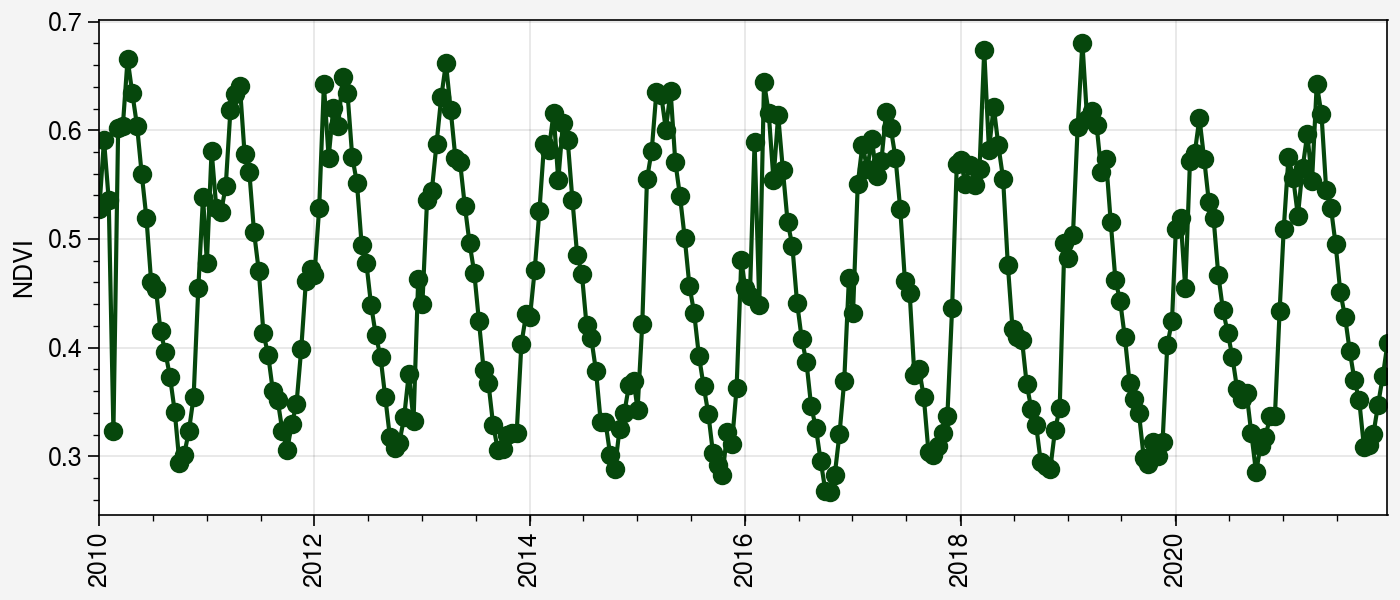

In [31]:
# mal_ndvi.dataframe can now be used as a pandas dataframe
fig, ax = plot.subplots(figsize=(7, 3), tight=True)
ax.plot(mal_ndvi.dataframe.index, mal_ndvi.dataframe['NDVI'],
        color='forest green', marker='o')
plot.show()

In [34]:
# the data is 16-day sampled data
mal_ndvi.dataframe.head()

,NDVI
2010-01-01,0.527277
2010-01-17,0.591015
2010-02-02,0.536247
2010-02-18,0.322971
2010-03-06,0.601685


In [33]:
mal_ndvi.dataframe.tail()

,NDVI
2021-10-16,0.310476
2021-11-01,0.320102
2021-11-17,0.347594
2021-12-03,0.373398
2021-12-19,0.403939


In [11]:
# Repeat with EVI
mal_evi = chart.Image.series(**{'imageCollection': scaled_evi,
                                   'region': mal,
                                   'reducer': ee.Reducer.mean(),
                                   'scale': 1000,
                                   'xProperty': 'system:time_start'})

In [12]:
# Convert 16-day sampled data to monthly averages
malawi_evi_monthly = mal_evi.dataframe.groupby(pd.Grouper(freq="M")).mean()
malawi_ndvi_monthly = mal_ndvi.dataframe.groupby(pd.Grouper(freq="M")).mean()

In [13]:
malawi_evi_monthly.head()

,EVI
2000-02-29,0.362193
2000-03-31,0.373737
2000-04-30,0.381332
2000-05-31,0.308848
2000-06-30,0.257063


In [14]:
malawi_evi_monthly.tail()

,EVI
2009-07-31,0.216556
2009-08-31,0.188016
2009-09-30,0.169807
2009-10-31,0.169293
2009-11-30,0.211458


In [57]:
# len(malawi_evi_monthly.index)

In [58]:
# malawi_evi_monthly.shape

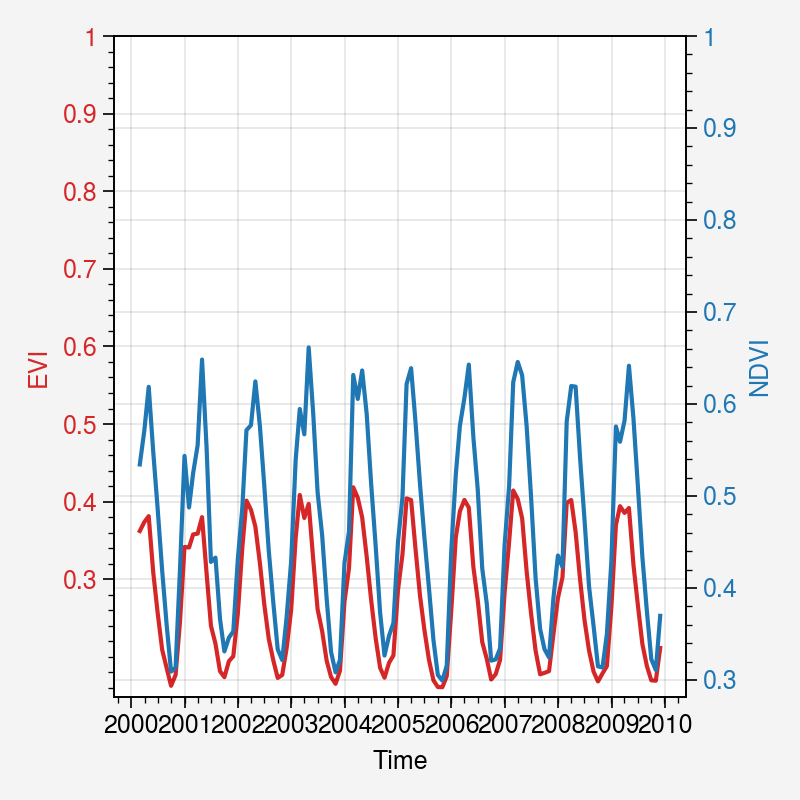

In [15]:
# x axis
time = malawi_evi_monthly.index

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Time')
ax1.set_ylabel('EVI',color=color)
ax1.plot(time, malawi_evi_monthly.iloc[:,0], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('NDVI', color=color)
ax2.plot(time, malawi_ndvi_monthly.iloc[:,0],color=color)
ax2.tick_params(axis='y', labelcolor=color)

# ax1.set_xlabel('Time')
# ax1.set_ylabel('EVI')
# ax2.set_ylabel('NDVI')
# plt.legend()

ax1.set_yticks(np.arange(0.3, 1.1, 0.1))
ax2.set_yticks(np.arange(0.3, 1.1, 0.1))

fig.tight_layout()
plt.show()

In [16]:
from pathlib import Path

country='Malawi'
date_range="2000-2009"
fp_NDVI = "NDVI_"+date_range+'.csv'
fp_EVI = "EVI_"+date_range+'.csv'
filepath_NDVI = Path(Path.cwd()/country/fp_NDVI)
filepath_EVI = Path(Path.cwd()/country/fp_EVI)



In [17]:
# save to csv
malawi_ndvi_monthly.to_csv(filepath_NDVI)

In [18]:
malawi_evi_monthly.to_csv(filepath_EVI)

# Section 2: To download Multiple Countries

In [3]:
import os

In [21]:
# coordinates of country boundaries
countries_cor = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')
modis = ee.ImageCollection('MODIS/006/MOD13Q1')

def extract_data(country, countries_cor, modis, dates):
    # Select Malawi feature from countries.
    country = ee.Feature(countries_cor.filter(ee.Filter.eq('country_na', country)).first())
    mod = modis.filterDate(ee.DateRange(date[0],date[1]))
    evi = mod.select('EVI')
    ndvi = mod.select('NDVI')
    scaled_evi = evi.map(scale_factor)
    scaled_ndvi = ndvi.map(scale_factor)
    c_ndvi = chart.Image.series(**{'imageCollection': scaled_ndvi,
                               'region': country,
                               'reducer': ee.Reducer.mean(),
                               'scale': 1000,
                               'xProperty': 'system:time_start'})
    c_evi = chart.Image.series(**{'imageCollection': scaled_evi,
                               'region': country,
                               'reducer': ee.Reducer.mean(),
                               'scale': 1000,
                               'xProperty': 'system:time_start'})
    c_evi_monthly = c_evi.dataframe.groupby(pd.Grouper(freq="M")).mean()
    c_ndvi_monthly = c_ndvi.dataframe.groupby(pd.Grouper(freq="M")).mean()
    return c_ndvi_monthly, c_evi_monthly
    
def scale_factor(image):
# scale factor for the MODIS MOD13Q1 product
    return image.multiply(0.0001).copyProperties(image,['system:time_start'])

dates = [['2000-01-01','2009-12-30'],['2010-01-01','2022-01-01']]
req_countries = ["Tunisia"]

        
        
    

In [22]:
for country in req_countries:
    for date in dates:
        ndvi,evi = extract_data(country,countries_cor,modis,date)
        filename_NDVI = "NDVI_"+date[0]+'_'+date[1]+'.csv'
        filename_EVI = "EVI_"+date[0]+'_'+date[1]+'.csv'
        path = str(Path(Path.cwd()/country))
        # Check whether the specified path exists or not
        isExist = os.path.exists(path)
        if not isExist:
            # Create a new directory because it does not exist 
            os.makedirs(path)
        ndvi.to_csv(path+filename_NDVI)
        evi.to_csv(path+filename_EVI)
    

EEException: User memory limit exceeded.

In [19]:
for i in dates:
    print(i[0],i[1])

2000-01-01 2009-12-01
2010-01-01 2022-01-01
